# Audio source separation

Requires `scipy==1.10.1` and `mdct==0.4`. 

Execute the next cell to install these libraries then restart the kernel.

In [267]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import scipy.io.wavfile as wavfile
import scipy.signal as signal
from scipy.spatial.distance import cdist

import IPython.display as ipd
from package import mdct, imdct
from scipy.io.wavfile import write

plt.rcParams['figure.figsize'] = (12,8)

In [268]:
# useful functions

def plot_sound(data, rate, title=None):
    if data.ndim == 1:
        data = data[:,np.newaxis]
    times = np.arange(data.shape[0])/rate
    plt.figure(figsize=(30,6))
    for channel in data.T:
        plt.fill_between(times, channel)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.xlim(times[0], times[-1])
    if title:
        plt.title(title)
    plt.show()
    
def play_sound(data, rate):
    return ipd.display(ipd.Audio(data.T, rate=rate))

T = 220501, M = 2


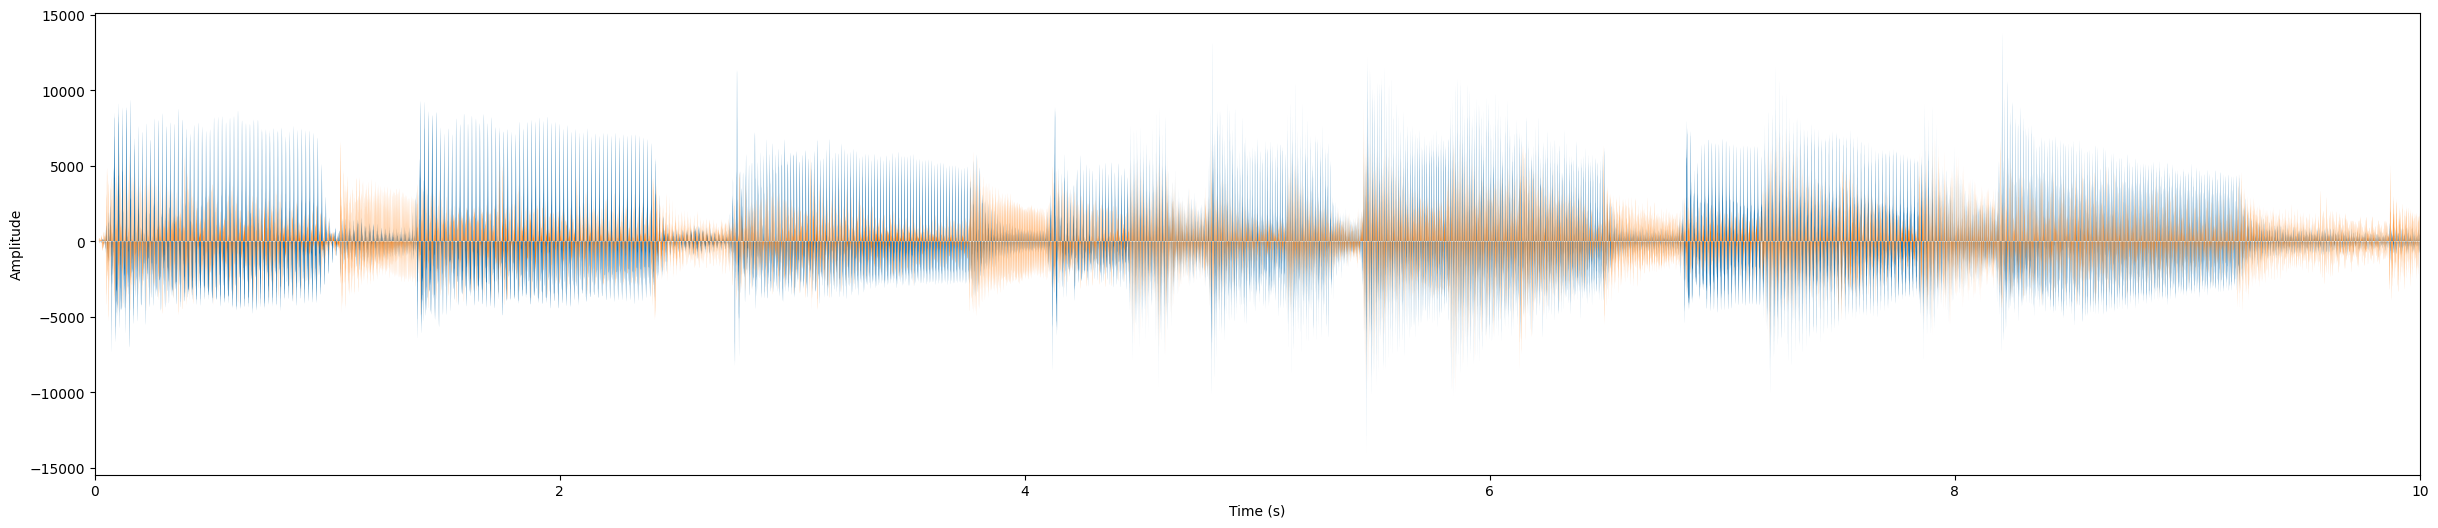

In [269]:
fname = 'mix.wav'

rate, x = wavfile.read(fname)
print('T = {:d}, M = {:d}'.format(*x.shape))
plot_sound(x, rate)
play_sound(x, rate)

In [270]:
write('new_mix.wav', rate, np.array(x, dtype=np.int16)) # to write a new wave file

(256, 863, 2) (256, 863)


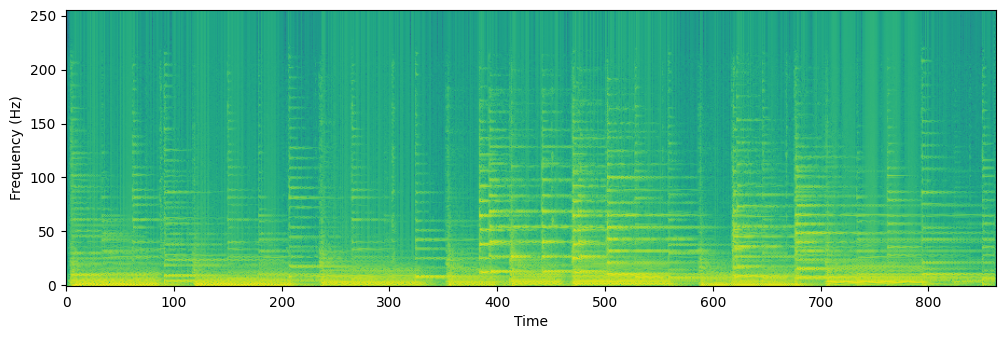

In [271]:
X = mdct(x, window=signal.windows.hamming, framelength=512)
Z = X.view(dtype=np.complex128)[...,0]

print(X.shape, Z.shape)

X_norm = np.abs(Z)**2


plt.imshow(np.log(X_norm+1e-10), origin='lower')
plt.xlabel('Time')
plt.ylabel('Frequency (Hz)')
plt.show()

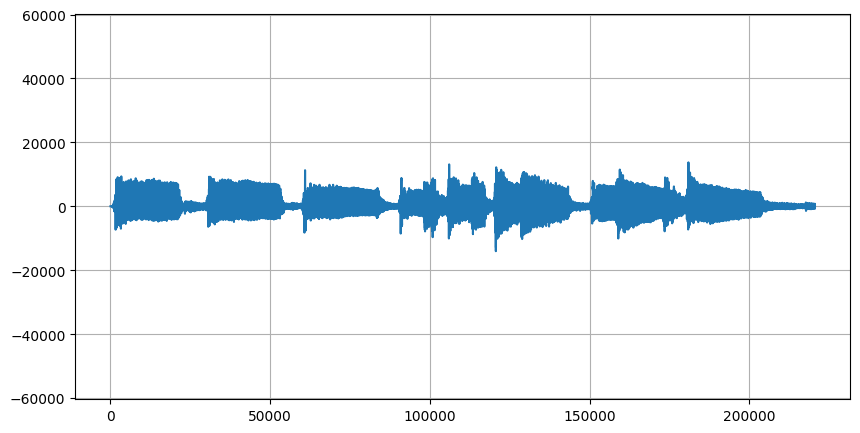

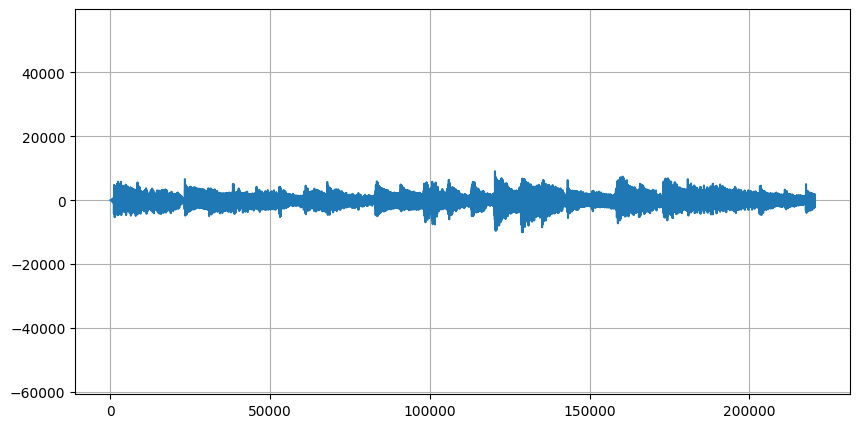

In [272]:
plt.figure(figsize=(10, 5))

plt.plot(x[:, 0])
plt.axis("equal")
plt.grid()
plt.show()


plt.figure(figsize=(10, 5))
plt.plot(x[:, 1])
plt.axis("equal")
plt.grid()
plt.show()

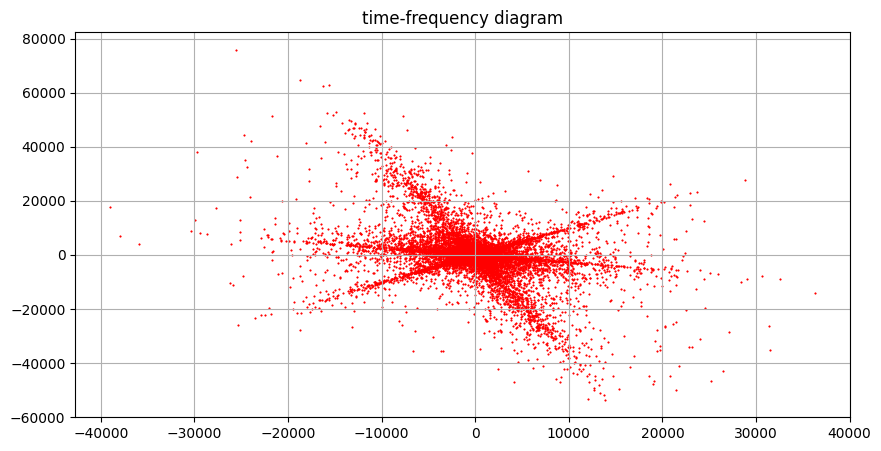

In [273]:
plt.figure(figsize=(10, 5))
plt.scatter(Z.imag.flatten(), Z.real.flatten(), color='red', linewidth=0.5, s = 1)
plt.title("time-frequency diagram")
plt.grid()
plt.show()

In [274]:
angles = np.arctan(Z.imag.flatten() / (Z.real.flatten() + 1e-10))

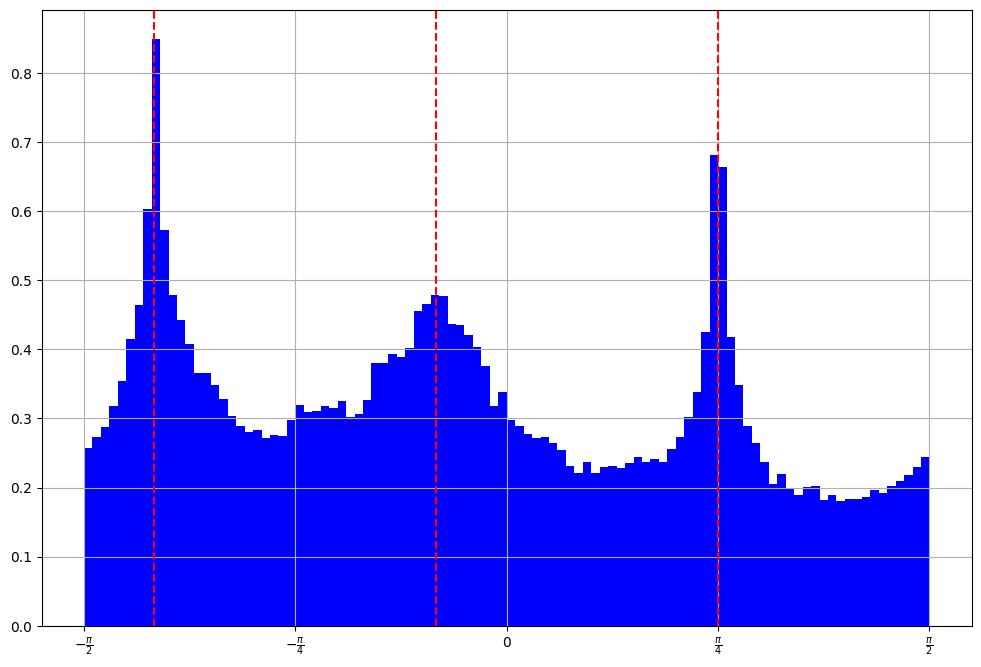

In [275]:
plt.hist(angles, color='blue', density=True, bins=100)
plt.axvline(np.pi/4, color='r', linestyle='--')
plt.axvline(-np.pi/12, color='r', linestyle='--')
plt.axvline(-5*np.pi/12, color='r', linestyle='--')
plt.xticks(np.linspace(-np.pi/2, np.pi/2, 5), labels=[r'$-\frac{\pi}{2}$', r'$-\frac{\pi}{4}$', r'$0$', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$'])
plt.grid()
plt.show()

Angles are -0.8, 1.2 , 0.3

In [276]:
import numpy as np


theta = np.array([-5*np.pi/12,-np.pi/12 , np.pi/4])
F, N = Z.shape
K = len(theta)

B = np.zeros((F, N, K), dtype=np.complex128)

angle_Z = np.angle(Z)  


for k in range(K):

    diff = theta[k] - angle_Z
    distance = np.abs(np.sin(diff))
    

    if k == 0:
        all_distances = distance[..., np.newaxis]
    else:
        all_distances = np.concatenate((all_distances, distance[..., np.newaxis]), axis=2)


closest_k = np.argmin(all_distances, axis=2) 


for k in range(K):
    B[:, :, k] = (closest_k == k)


In [277]:
Y = np.zeros((X.shape[0], X.shape[1], X.shape[2], 3), dtype=np.complex128)  # shape (F, N, M, K)
print(X.shape)
print(Y.shape)
for k in range(K):
    for m in range(2):  
        Y[:, :, m, k] = Z * B[:, :, k]

(256, 863, 2)
(256, 863, 2, 3)


In [278]:
Y[:, :, 1, 0].imag

array([[ 0.00000000e+00, -2.16115799e+02, -4.32445137e+02, ...,
         7.26158066e+02, -1.34612098e+03,  4.70334972e+01],
       [ 0.00000000e+00, -2.22483213e+02, -3.62713316e+02, ...,
         3.48376978e+03,  2.41460620e+03, -0.00000000e+00],
       [-0.00000000e+00, -1.82652459e+02, -7.43627421e+02, ...,
        -1.57556753e+03, -0.00000000e+00, -1.54607529e+02],
       ...,
       [-0.00000000e+00, -1.62365677e-01,  0.00000000e+00, ...,
         5.12447446e+00, -1.62395122e+01,  3.18577438e+00],
       [ 0.00000000e+00,  9.13021818e-02, -0.00000000e+00, ...,
        -5.03700399e+00, -3.88438439e+00,  0.00000000e+00],
       [ 0.00000000e+00,  1.07873210e-01,  0.00000000e+00, ...,
        -4.98832165e+00,  1.22763664e+00, -8.98825349e+00]])

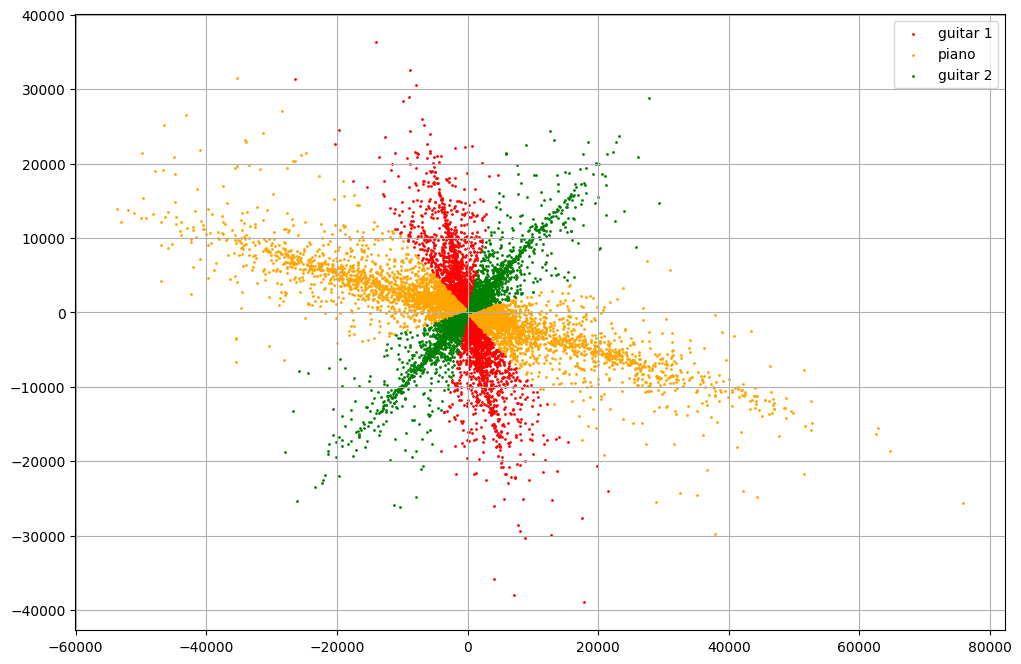

In [279]:
plt.scatter(Y[:, :, 1, 0].real.flatten(), Y[:, :, 1, 0].imag.flatten(), color='red', label='guitar 1', s = 1)
plt.scatter(Y[:, :, 1, 1].real.flatten(), Y[:, :, 1, 1].imag.flatten(), color='orange', label='piano', s = 1)
plt.scatter(Y[:, :, 1, 2].real.flatten(), Y[:, :, 1, 2].imag.flatten(), color='green', label='guitar 2', s = 1)

plt.legend()
plt.grid()
plt.show()

In [280]:
y = imdct(Y[:, :, :, 1], window = signal.windows.hamming, framelength=512)
y.shape

(220672, 2)

In [281]:
write('source_1.wav', rate, np.array(y[:, 0], dtype=np.int16))

In [282]:
play_sound(y[:, 0], rate)

In [283]:
A = Z / np.sqrt(np.abs(Z) + 1e-10)

In [284]:
# print(A.shape, Z.shape)
# sigma_xx = A @ Z @ A.T.conj

In [285]:
Z_copy = Z.copy()
Z_copy *= np.exp(1j* np.pi/2)
X_rotated = np.zeros(X.shape)

X_rotated[:, :, 0] = Z_copy.real
X_rotated[:, :, 1] = Z_copy.imag

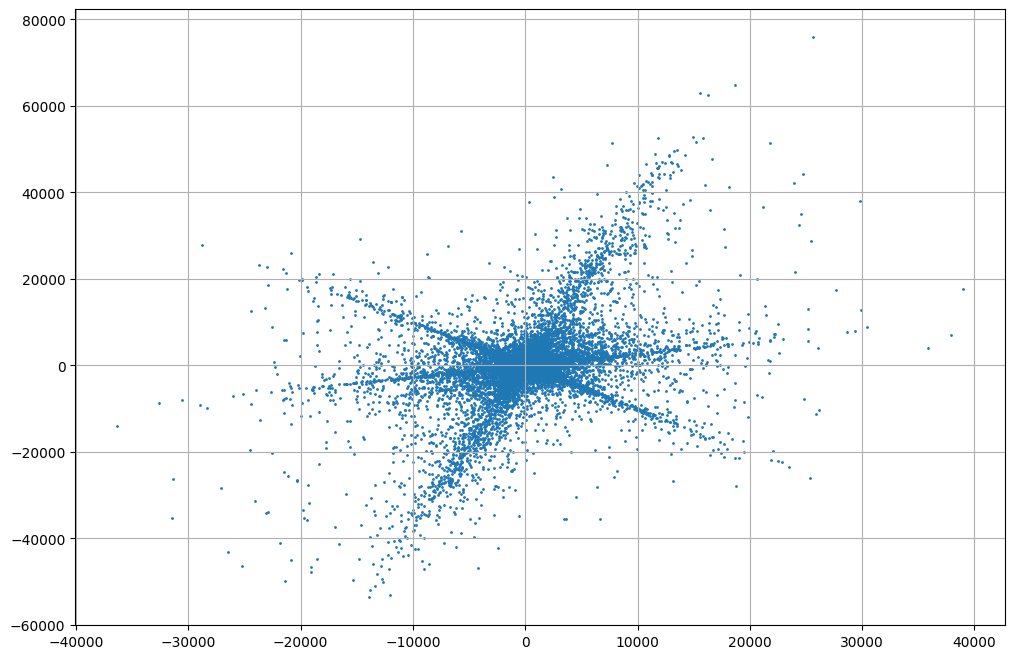

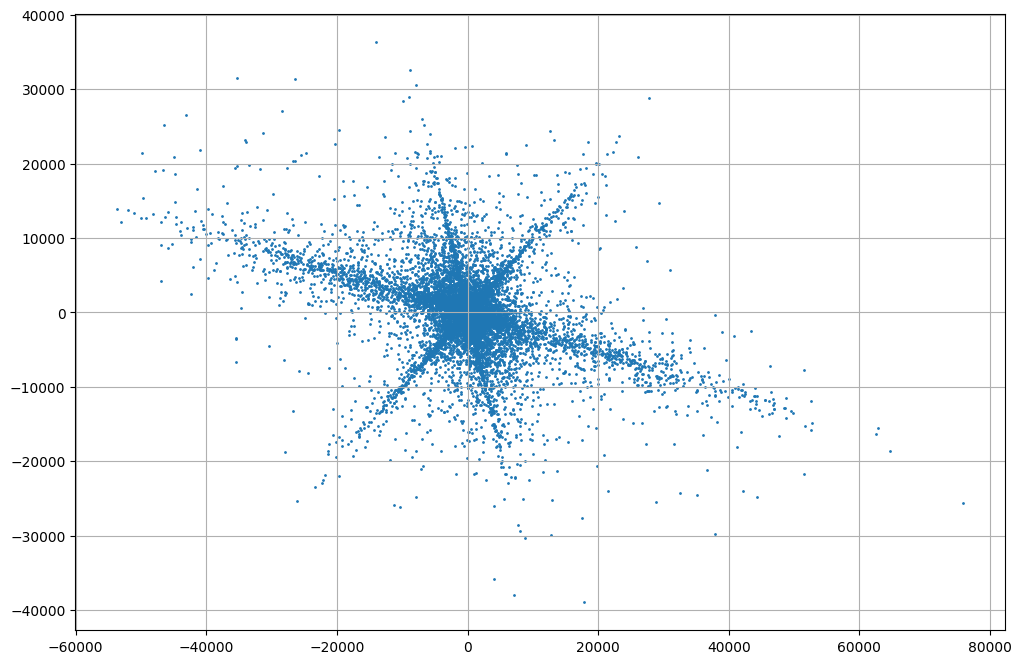

In [286]:
X1 = X_rotated[:, :, 0]
X2 = X_rotated[:, :, 1]

plt.figure()
plt.scatter(X1, X2, s = 1)
plt.grid()
plt.show()

plt.figure()
plt.scatter(Z.real.flatten(), Z.imag.flatten(), s = 1)
plt.grid()
plt.show()

In [287]:
x_reconstructed = imdct(X_rotated, window = signal.windows.hamming, framelength=512)
play_sound(x_reconstructed, rate)